# Import essential libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
import pyLDAvis.sklearn
from statsmodels.tsa.stattools import grangercausalitytests

C:\Users\JHuamani\Anaconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [2]:
import numpy as np
from sklearn.utils import check_random_state
from sklearn.decomposition._online_lda_fast import _dirichlet_expectation_2d
class PTW_LDA(LatentDirichletAllocation):

    def __init__(self, n_components=10, *, doc_topic_prior=None,
                 topic_word_prior=None, learning_method='batch',
                 learning_decay=.7, learning_offset=10., max_iter=10,
                 batch_size=128, evaluate_every=-1, total_samples=1e6,
                 perp_tol=1e-1, mean_change_tol=1e-3, max_doc_update_iter=100,
                 n_jobs=None, verbose=0, random_state=None, 
                 ptws=None):
        super(PTW_LDA, self).__init__(n_components, doc_topic_prior, topic_word_prior, 
                                      learning_method, learning_decay, learning_offset, 
                                      max_iter, batch_size, evaluate_every, total_samples, 
                                      perp_tol, mean_change_tol, max_doc_update_iter, 
                                      n_jobs, verbose, random_state)
        self.ptws = ptws

    def _init_latent_vars(self, n_features):
        """Initialize latent variables."""

        self.random_state_ = check_random_state(self.random_state)
        self.n_batch_iter_ = 1
        self.n_iter_ = 0

        if self.doc_topic_prior is None:
            self.doc_topic_prior_ = 1. / self.n_components
        else:
            self.doc_topic_prior_ = self.doc_topic_prior

        if self.topic_word_prior is None:
            self.topic_word_prior_ = 1. / self.n_components
        else:
            self.topic_word_prior_ = self.topic_word_prior

        init_gamma = 100.
        init_var = 1. / init_gamma
        # In the literature, this is called `lambda`
        self.components_ = self.random_state_.gamma(
            init_gamma, init_var, (self.n_components, n_features))

        # Transform topic values in matrix for prior topic words
        if self.ptws is not None:
            for ptw in self.ptws:
                word_index = ptw[0]
                word_topic_values = ptw[1]
                self.components_[:, word_index] *= word_topic_values

        # In the literature, this is `exp(E[log(beta)])`
        self.exp_dirichlet_component_ = np.exp(
            _dirichlet_expectation_2d(self.components_))

In [3]:
def lemma_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [4]:
# Merge NYT data
main_df = pd.read_csv('NYT2000_1.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
temp_df = pd.read_csv('NYT2000_2.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
main_df = pd.concat([main_df,temp_df], ignore_index=True)

In [5]:
# Remove NaN values, lowercase contents of Body column, filters for bush and gore and resets the index
main_df.dropna(subset=['Body'], inplace=True)
main_df['Body'] = main_df['Body'].str.lower()
main_df = main_df[main_df['Body'].str.contains('gore|bush')]
main_df = main_df.reset_index(drop=True)

print(main_df.shape)
print(main_df['Body'].head(10))

(4706, 4)
0    just before the july 4 recess, a senate commit...
1    george w. bush -- pittsburgh and east brunswic...
2    drivers have been paying almost twice as much ...
3    for farmers, the months leading to harvest tim...
4    international a3-13 u.s. and vietnam reach bro...
5    dna test fails to exonerate prisoner given sta...
6    former senator bill bradley made it official t...
7    from his opening salutation ''i am a member of...
8    the democratic national committee's new televi...
9    several homeowners, cell phones at hand, tend ...
Name: Body, dtype: object


In [6]:
# Create a single date column from day, month and year columns
main_df['Date'] = pd.to_datetime(
    main_df['Publication Year'] * 10000 + main_df['Publication Month'] * 100 + main_df['Publication Day Of Month'],
    format='%Y%m%d')
main_df.drop(['Publication Year', 'Publication Month', 'Publication Day Of Month'], axis=1, inplace=True)

print(main_df.head(10))

                                                Body       Date
0  just before the july 4 recess, a senate commit... 2000-07-13
1  george w. bush -- pittsburgh and east brunswic... 2000-07-13
2  drivers have been paying almost twice as much ... 2000-07-13
3  for farmers, the months leading to harvest tim... 2000-07-13
4  international a3-13 u.s. and vietnam reach bro... 2000-07-13
5  dna test fails to exonerate prisoner given sta... 2000-07-13
6  former senator bill bradley made it official t... 2000-07-13
7  from his opening salutation ''i am a member of... 2000-07-13
8  the democratic national committee's new televi... 2000-07-13
9  several homeowners, cell phones at hand, tend ... 2000-07-13


In [7]:
# Remove unnecessary symbols, numbers, words less than 3 characters and apply lemmatizer
main_df['Body'].replace([r'[,\.!?]', r'\d+', r'\b(\w{1,2})\b'], '', inplace=True, regex=True)
main_df['Body'].apply(lemma_text)
main_df['Body'] = main_df['Body'].str.replace('said', '', regex=False)

print(main_df.head(10))

                                                Body       Date
0  just before the july  recess  senate committee... 2000-07-13
1  george  bush -- pittsburgh and east brunswick ... 2000-07-13
2  drivers have been paying almost twice  much fo... 2000-07-13
3  for farmers the months leading  harvest time a... 2000-07-13
4  international -  and vietnam reach broad trade... 2000-07-13
5  dna test fails  exonerate prisoner given stay ... 2000-07-13
6  former senator bill bradley made  official tod... 2000-07-13
7  from his opening salutation ''   member  the n... 2000-07-13
8  the democratic national committee' new televis... 2000-07-13
9  several homeowners cell phones  hand tend thei... 2000-07-13


In [8]:
#Read the IEM data and Normalize one of the stocks
iem_data = pd.read_excel('IEM2000.xlsx')
iem_data.drop(['Units', '$Volume', 'LowPrice','HighPrice','AvgPrice'], axis=1, inplace=True)

dem_data = iem_data[iem_data['Contract'].str.contains('Dem')]
rep_data = iem_data[iem_data['Contract'].str.contains('Rep')]

dem_data.set_index('Date', inplace=True)
rep_data.set_index('Date', inplace=True)

dem_data['NormLastPrice'] = dem_data['LastPrice'] / (dem_data['LastPrice'] + rep_data['LastPrice'])
dem_data.drop(['LastPrice', 'Contract'], axis=1, inplace=True)

print(dem_data.head())

            NormLastPrice
Date                     
2000-05-01       0.523810
2000-05-02       0.504970
2000-05-03       0.509491
2000-05-04       0.511466
2000-05-05       0.520875


C:\Users\JHuamani\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\JHuamani\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\JHuamani\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
<ipython-input-8-7b4d2e914db2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [9]:
# Generate feature vector and document vs. term matrix
# Note: the individual matrix values are term frequencies for each document
cv = CountVectorizer(stop_words='english', max_df=3500)
ft_cv = cv.fit_transform(main_df['Body'])
vocabulary = cv.get_feature_names()
doc_term_matrix = pd.DataFrame(ft_cv.toarray(), columns=vocabulary)

print(doc_term_matrix.shape)
print(doc_term_matrix.head())

(4706, 63104)
   aaa  aab  aabb  aachen  aakporg  aalto  aan  aardvark  aaron  aaronson  \
0    0    0     0       0        0      0    0         0      0         0   
1    0    0     0       0        0      0    0         0      0         0   
2    0    0     0       0        0      0    0         0      0         0   
3    0    0     0       0        0      0    0         0      0         0   
4    0    0     0       0        0      0    0         0      0         0   

   ...  zuylen  zvi  zwerger  zwilling  zwirn  zwirner  zydeco  zygmunt  \
0  ...       0    0        0         0      0        0       0        0   
1  ...       0    0        0         0      0        0       0        0   
2  ...       0    0        0         0      0        0       0        0   
3  ...       0    0        0         0      0        0       0        0   
4  ...       0    0        0         0      0        0       0        0   

   zymogenetics  zyzzyva  
0             0        0  
1             0   

In [10]:
# Generate word stream
# Note: the individual matrix value are term frequencies for each date
doc_term_matrix['Date'] = main_df['Date']
aggregator_words = {i: 'sum' for i in vocabulary}
word_stream = doc_term_matrix.groupby(['Date']).agg(aggregator_words)

print(word_stream.shape)
print(word_stream.head())

(194, 63104)
            aaa  aab  aabb  aachen  aakporg  aalto  aan  aardvark  aaron  \
Date                                                                       
2000-05-01    0    0     0       0        0      0    0         0      0   
2000-05-02    0    0     0       0        0      0    0         0      0   
2000-05-03    0    0     0       0        0      0    0         0      0   
2000-05-04    0    0     0       0        0      0    0         0      0   
2000-05-05    0    0     0       0        0      0    0         0      0   

            aaronson  ...  zuylen  zvi  zwerger  zwilling  zwirn  zwirner  \
Date                  ...                                                   
2000-05-01         0  ...       0    0        0         0      5        0   
2000-05-02         0  ...       0    0        0         0      0        0   
2000-05-03         0  ...       0    0        0         0      0        0   
2000-05-04         0  ...       0    0        0         2      0     

In [11]:
# Add IEM Stock data to word_stream
combined_word_dem_data = pd.concat([dem_data, word_stream], axis=1, join='inner')
print(combined_word_dem_data.head())
print(pd.date_range(start='2000-05-01',end='2000-11-10').difference(combined_word_dem_data.index))

            NormLastPrice  aaa  aab  aabb  aachen  aakporg  aalto  aan  \
Date                                                                     
2000-05-01       0.523810    0    0     0       0        0      0    0   
2000-05-02       0.504970    0    0     0       0        0      0    0   
2000-05-03       0.509491    0    0     0       0        0      0    0   
2000-05-04       0.511466    0    0     0       0        0      0    0   
2000-05-05       0.520875    0    0     0       0        0      0    0   

            aardvark  aaron  ...  zuylen  zvi  zwerger  zwilling  zwirn  \
Date                         ...                                          
2000-05-01         0      0  ...       0    0        0         0      5   
2000-05-02         0      0  ...       0    0        0         0      0   
2000-05-03         0      0  ...       0    0        0         0      0   
2000-05-04         0      0  ...       0    0        0         2      0   
2000-05-05         0      0  ..

In [12]:
# Fit LDA model to feature vector
k = 15
#prior_topic_words = []
#prior_topic_words.append((vocabulary.index('oil'), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0]))
#print(prior_topic_words)

lda = PTW_LDA(n_components=15, learning_method='online') #ptws=prior_topic_words)

lda.fit(ft_cv)

print('log likelihood score, ' + str(k) + ' topics: ' + str(lda.score(ft_cv)))

pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(lda, ft_cv, cv)
pyLDAvis.display(p)

C:\Users\JHuamani\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17596078.500924114


        aaa       aab      aabb    aachen   aakporg     aalto       aan  \
0  0.066668  0.066669  0.066694  0.066668  0.066668  0.066668  0.066668   
1  0.066668  0.066669  0.066668  0.066668  0.066673  0.066668  0.066668   
2  0.066673  0.066682  0.066671  0.066671  0.066668  0.066739  0.066868   
3  0.066668  0.066668  0.066668  0.066668  0.066668  0.066668  0.066736   
4  0.066668  0.066668  0.066668  1.268659  0.066668  0.066668  0.066668   

   aardvark     aaron  aaronson  ...    zuylen       zvi   zwerger  zwilling  \
0  0.066668  0.066670  0.066668  ...  0.066668  1.095447  0.066668  0.066668   
1  0.066668  0.066669  0.066668  ...  0.066668  0.066668  0.066669  0.066668   
2  0.825932  6.531705  0.067082  ...  0.067020  0.066673  1.059497  0.066671   
3  0.066668  0.066668  0.066668  ...  0.164612  0.066670  0.066668  0.066677   
4  0.066668  0.066668  0.066668  ...  0.066668  0.066686  0.066668  0.066668   

      zwirn   zwirner    zydeco   zygmunt  zymogenetics   zyzzyva  


<Figure size 1152x720 with 0 Axes>

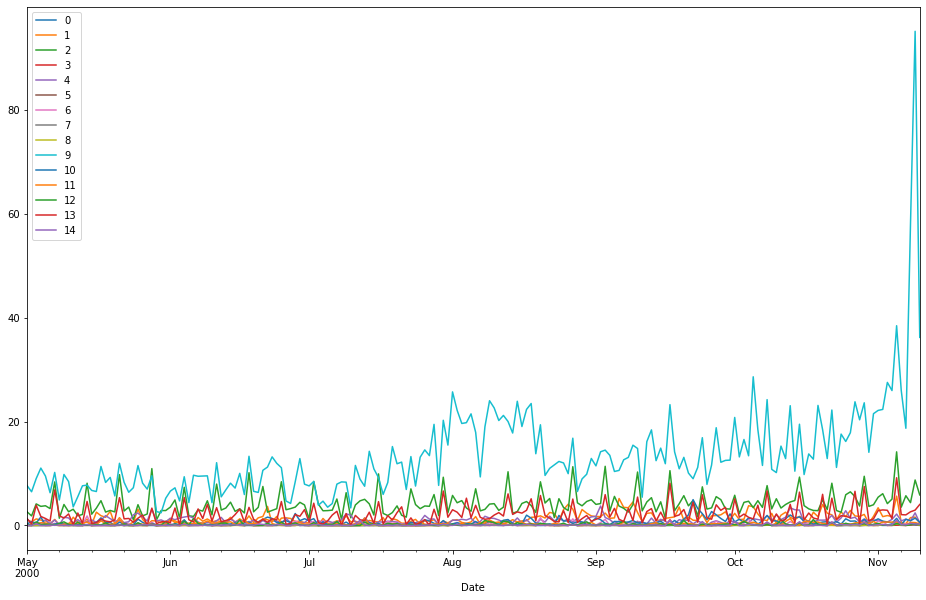

In [13]:
# Generate topic vs. word matrix
# Note: the individual matrix values are pseudo counts NOT probabilities
topic_word_matrix = pd.DataFrame(lda.components_, columns=vocabulary)
print(topic_word_matrix.head())

# Generate document vs. topic coverage matrix
lda_out = lda.transform(ft_cv)
doc_topic_matrix = pd.DataFrame(lda_out)
doc_topic_matrix['Date'] = main_df['Date']
print(doc_topic_matrix.shape)

# Aggregate topic coverages by each date and create topic_stream
aggregator_topics = {i: 'sum' for i in range(k)}
topic_stream = doc_topic_matrix.groupby(['Date']).agg(aggregator_topics)
print(topic_stream.head())

# Plot resulting topic streams
plt.rcParams['figure.figsize'] = [16, 10]
plt.figure()
topic_stream.plot()
plt.show()

In [14]:
# Prepare dem_data and topic_stream for Granger tests
combined_topic_dem_data = pd.concat([dem_data, topic_stream], axis=1, join='inner')
print(combined_topic_dem_data.head())
print(pd.date_range(start='2000-05-01',end='2000-11-10').difference(combined_topic_dem_data.index))

granger_results1 = grangercausalitytests(combined_topic_dem_data[['NormLastPrice',2]],5)
granger_results2 = grangercausalitytests(combined_topic_dem_data[['NormLastPrice',7]],5)
granger_results3 = grangercausalitytests(combined_topic_dem_data[['NormLastPrice',10]],5)
granger_results4 = grangercausalitytests(combined_topic_dem_data[['NormLastPrice',11]],5)
granger_results5 = grangercausalitytests(combined_topic_dem_data[['NormLastPrice',12]],5)

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.002974  1.100931  2.651183  0.002974  1.206344   
2000-05-02       0.504970  0.009597  0.711508  1.848433  0.009597  0.557326   
2000-05-03       0.509491  0.019451  1.267778  4.155149  0.255597  0.264193   
2000-05-04       0.511466  0.014654  1.038385  3.682179  0.160955  0.419918   
2000-05-05       0.520875  0.011935  0.906515  3.796351  0.011935  1.088107   

                   5         6         7         8          9        10  \
Date                                                                      
2000-05-01  0.005650  0.209782  0.002974  0.069667   7.700901  0.312691   
2000-05-02  0.009597  0.156667  0.064142  0.009597   6.494597  0.722084   
2000-05-03  0.010849  0.089150  0.048800  0.014171   9.031182  0.474156   
2000-05-04  0.025143  0.412964  0.115654  0.016791  11.044893  1.625272

In [15]:
# Sort significant topic by pseudo count in descending order
top_topic = 10
test_sort = topic_word_matrix.loc[top_topic].sort_values(ascending=False)

# Choose l # of top words from top topic
l = 10
top_l_words_of_topic = test_sort.index[:l]
print(test_sort.head(l))
print(top_l_words_of_topic)

oil          1532.030721
company      1195.695113
companies    1004.644145
industry      787.230145
prices        783.267516
million       634.922254
business      568.629589
percent       528.778393
market        526.702586
price         506.921423
Name: 10, dtype: float64
Index(['oil', 'company', 'companies', 'industry', 'prices', 'million',
       'business', 'percent', 'market', 'price'],
      dtype='object')



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0592  , p=0.8081  , df_denom=190, df_num=1
ssr based chi2 test:   chi2=0.0601  , p=0.8063  , df=1
likelihood ratio test: chi2=0.0601  , p=0.8063  , df=1
parameter F test:         F=0.0592  , p=0.8081  , df_denom=190, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0543  , p=0.9472  , df_denom=187, df_num=2
ssr based chi2 test:   chi2=0.1115  , p=0.9458  , df=2
likelihood ratio test: chi2=0.1115  , p=0.9458  , df=2
parameter F test:         F=0.0543  , p=0.9472  , df_denom=187, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4523  , p=0.7160  , df_denom=184, df_num=3
ssr based chi2 test:   chi2=1.4086  , p=0.7035  , df=3
likelihood ratio test: chi2=1.4035  , p=0.7047  , df=3
parameter F test:         F=0.4523  , p=0.7160  , df_denom=184, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5220  , p=0.7197  

<Figure size 1152x720 with 0 Axes>

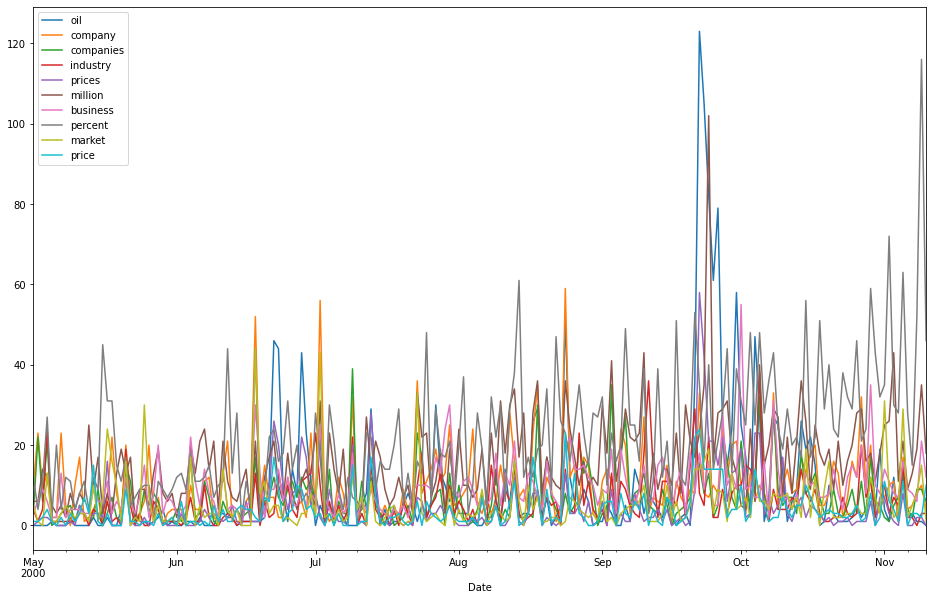

In [16]:
# Granger results for words
granger_results10 = grangercausalitytests(combined_word_dem_data[['NormLastPrice',top_l_words_of_topic[0]]],5)

# Filter word stream to top l words
test_stream = word_stream[top_l_words_of_topic]

# Plot resulting topic streams
plt.rcParams['figure.figsize'] = [16, 10]
plt.figure()
test_stream.plot()
plt.show()

In [17]:
# Get Pearson Correlation Coefficients

print(combined_word_dem_data[top_l_words_of_topic].corrwith(combined_word_dem_data['NormLastPrice']))

oil          0.174264
company     -0.031504
companies    0.105990
industry     0.102111
prices       0.190583
million      0.117860
business     0.048901
percent      0.201376
market       0.013508
price        0.142080
dtype: float64
